目标检测之Fast RCNN算法
===

# 1.RCNN的缺陷与Fast RCNN的改进

## 1.1.RCNN的缺陷
- RCNN一张图像内候选框之间大量重叠，提取特征操作冗余
- 由于提取特征操作冗余，所以训练时速度很慢
- RCNN中独立的分类器和回归器需要大量特征作为训练样本，所以训练时所需空间较大

## 1.2.Fast RCNN的改进
针对RCNN的问题，Fast RCNN从以下三个方面进行了改进：

### 1.2.1.测试时速度慢 
RCNN一张图像内候选框之间大量重叠，提取特征操作冗余。本文将整张图像归一化后直接送入深度网络。在邻接时，才加入候选框信息，在末尾的少数几层处理每个候选框。

### 1.2.2.训练时速度慢 
原因同上。在训练时，本文先将一张图像送入网络，紧接着送入从这幅图像上提取出的候选区域。这些候选区域的前几层特征不需要再重复计算。

### 1.2.3.训练所需空间大 
RCNN中独立的分类器和回归器需要大量特征作为训练样本。把类别判断和位置精调统一用深度网络实现，不再需要额外存储。

## 3.3.总结
RCNN主要是使用Selective Search算法计算出Proposal，然后送入SVM进行分类训练，然后送入一个CNN的回归网络进行bounding box的训练。而Fast RCNN仍然需要使用Selective Search算法计算出Proposal，只是它将后续的分类训练和回归训练合并到了一个CNN网络中，不在需要进行两步操作(ROI层)<br/>
![images](Images/01_03_001.png)


# 1.网络结构
![images](Images/01_03_002.jpg)

# 1.1.基础网络
Fast RCNN的网络结构如上图，在ROI Pooling层之前的是一个完整的Vgg16网络，只不过是将ROI Pooling替换掉了最后一个MaxPooling层，所以通常情况下输入$224 \times 224$的图片，到ROI Pooling之前特征图的大小为$bs,512,14,14$

# 1.2.ROI Pooling层
对ROI来说，无论输入的特征图是什么尺寸，ROI都会将输出的特征图变为$7 \times 7$的大小，所以ROI其实是单层的SPP

# 1.3.全连接层
后续接两个全连接层，最终输出4096大小

# 2.多任务损失函数
在Fast RCNN中，使用多任务loss代替了SVM。

## 2.1.分类损失函数$L_{cls}$
使用SoftmaxLoss代替SVM。对于分类结果，首先执行NMS，去掉一些重复的框，留下分数最高的剩余的框根据分类结果是不是背景
- 是背景：直接去掉
- 不是背景：把他的Label分配为最大的score，然后通过BBox回归结果反向作用在Anchor上生成最终的框位置

设$p=\{p_0,p_1,...,p_n\}$是候选区域集合，则$L_{cls}$是一个$K+1$类的分类任务，其中输入数据是经过卷积和全连接之后提取的特征向量

输出数据是候选区域的类别(u)，包括K类物体(u≥1)和1类背景(u=0)。分类任务的损失函数是softmax损失。

## 2.2.回归损失函数$L_{conf}$
对于候选区域所属的类别u,$v=\{v_x,v_y,v_w,y_h\}$表示候选区域的ground-truth.$t^u=\{t_x^u,t_y^u,t_w^u,t_h^u\}$表示对候选区域的类别$u(u \geq 1)$的位置预测

损失函数是smoothL1，表示为
$$L_{loc}(t^u,v)=\sum_{i \in x,y,w,h}smooth_{L1}(t_i^u,v_i)$$
其中
$$
smooth_{L1}(x)=\begin{cases}
0.5x^2 &|x| < 1 \\
|x|-0.5 & otherwise
\end{cases}
$$

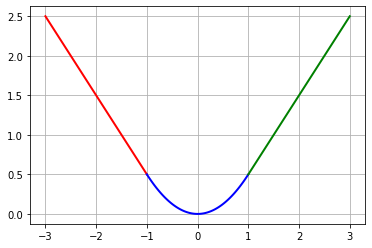

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x1 = np.linspace(-3, -1, 100)
y1 = np.abs(x1) - 0.5

x2 = np.linspace(-1, 1, 100)
y2 = 0.5 * np.power(x2, 2)

x3 = np.linspace(1, 3, 100)
y3 = np.abs(x3) - 0.5

plt.figure(facecolor='w')
plt.plot(x1, y1, 'r-', linewidth=2)
plt.plot(x2, y2, 'b-', linewidth=2)
plt.plot(x3, y3, 'g-', linewidth=2)
plt.grid()

# 3.总结
Fast RCNN解决了SPP和RCNN的大部分问题，剩下最后的一个问题没有解决，那就是候选框的提取过程，这个过程依旧非常耗时(SS算法)